In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf, validate_on
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms
import numpy as np
LEARNING_RATE = 0.0001

0.90 - For proving that using pre-trained model works better

In [2]:
# train_ds, val_ds, label_names = dataset_tf("./dataset/sbcm_hive_1_train_copy", 0.30, 16)
# train_ds, val_ds, label_names = dataset_tf("./dataset/pitched_transformed_train", 0.50, 16)
train_ds, val_ds, label_names = dataset_tf("dataset/sbcm_hive_1_train", 0.80, 16)

Found 560 files belonging to 2 classes.
Using 280 files for training.
Using 280 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (16, 4000)
Example label shape: (16,)


2024-03-28 23:50:46.254434: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-28 23:50:46.254458: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-28 23:50:46.254466: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-28 23:50:46.254500: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-28 23:50:46.254516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [3]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)
train_spectrogram_ds = to_spectrogram_dataset(train_ds)
val_spectrogram_ds = to_spectrogram_dataset(val_ds)

513 44100
513 44100


# Train raw models

## Raw - MFCCs

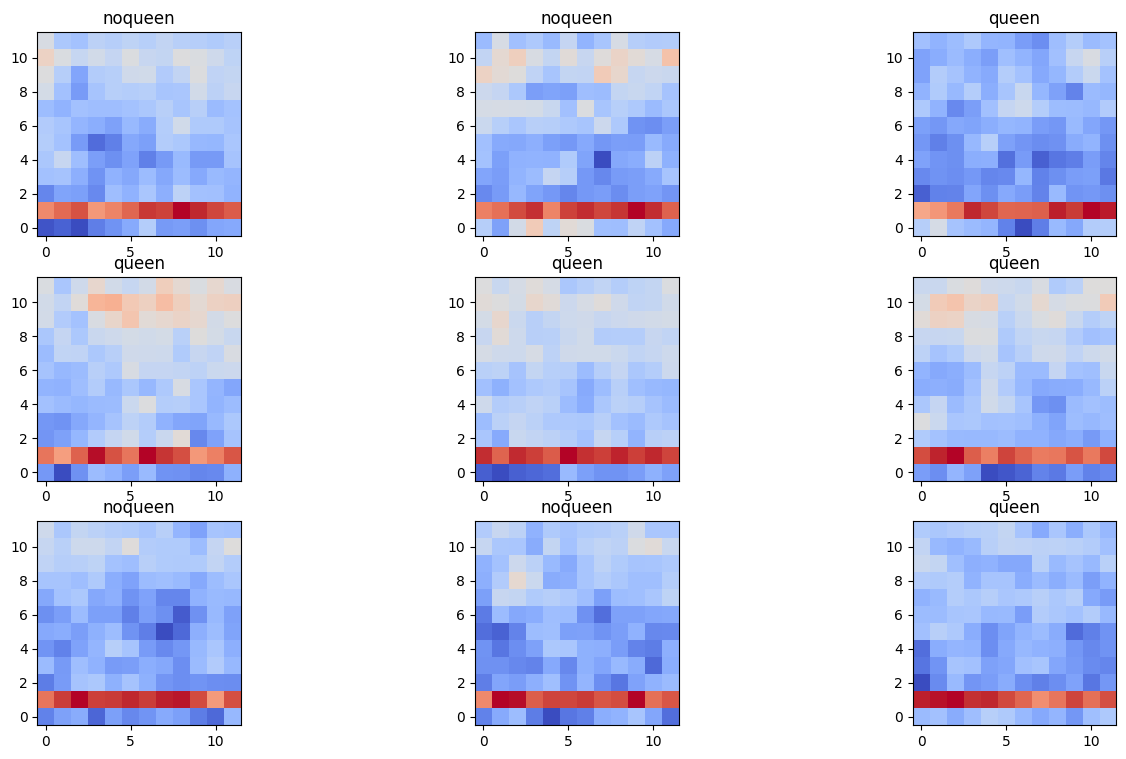

In [4]:
for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break

plot_mfccs(example_mfccs, example_mfccs_labels, label_names)

In [5]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))

for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break
input_shape = example_mfccs.shape[1:]
input_shape

TensorShape([12, 12, 1])

In [6]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [MFCCs] Sequential Model

2024-03-28 23:50:47.748082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20


2024-03-28 23:50:48.327814: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


18/18 [==============================] - 1s 36ms/step - loss: 0.7308 - accuracy: 0.5071 - val_loss: 0.6743 - val_accuracy: 0.5786
Epoch 2/20
18/18 [==============================] - 0s 14ms/step - loss: 0.6457 - accuracy: 0.6393 - val_loss: 0.6581 - val_accuracy: 0.5571
Epoch 3/20
18/18 [==============================] - 0s 15ms/step - loss: 0.5963 - accuracy: 0.6893 - val_loss: 0.6330 - val_accuracy: 0.5821
Epoch 4/20
18/18 [==============================] - 0s 14ms/step - loss: 0.5489 - accuracy: 0.7500 - val_loss: 0.6020 - val_accuracy: 0.6250
Epoch 5/20
18/18 [==============================] - 0s 14ms/step - loss: 0.4867 - accuracy: 0.8000 - val_loss: 0.6382 - val_accuracy: 0.5714
Epoch 6/20
18/18 [==============================] - 0s 15ms/step - loss: 0.4270 - accuracy: 0.8429 - val_loss: 0.5507 - val_accuracy: 0.7143
Epoch 7/20
18/18 [==============================] - 0s 14ms/step - loss: 0.3730 - accuracy: 0.8607 - val_loss: 0.5395 - val_accuracy: 0.7214
Epoch 8/20
18/18 [======

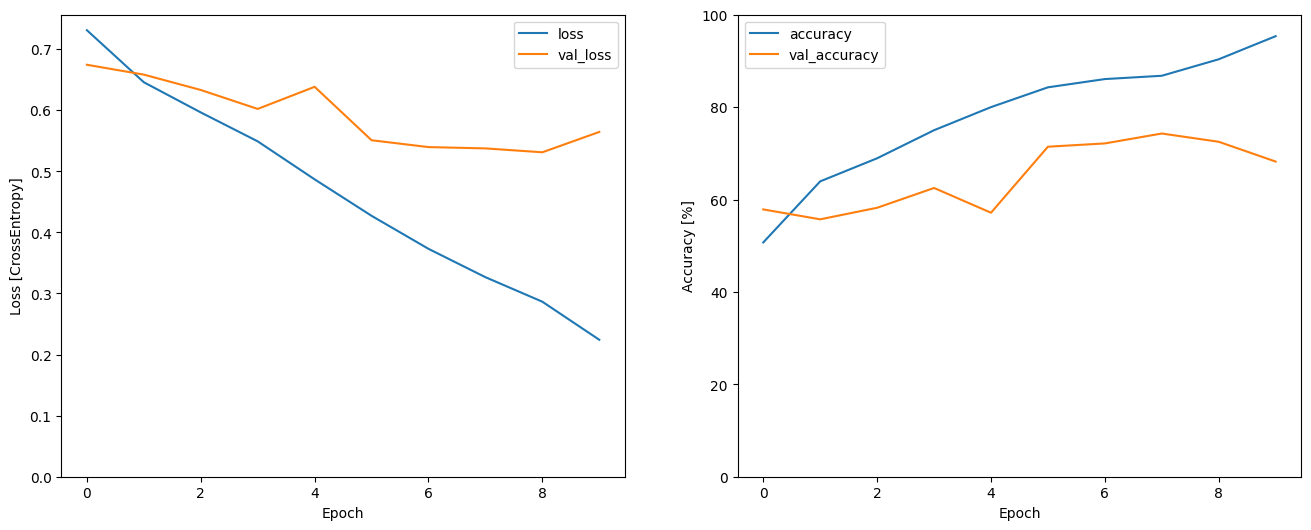

In [7]:
model_mfcc_seq = get_seq_model(input_shape, len(label_names), train_mfccs_ds)
model_mfcc_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_mfcc_seq = model_mfcc_seq.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_seq)

### [Reinf:Raw] [MFCCs] Convolutional Model (mini)

Epoch 1/20
18/18 [==============================] - 1s 18ms/step - loss: 0.7863 - accuracy: 0.5000 - val_loss: 0.7357 - val_accuracy: 0.5000
Epoch 2/20
18/18 [==============================] - 0s 7ms/step - loss: 0.7179 - accuracy: 0.5143 - val_loss: 0.6957 - val_accuracy: 0.5357
Epoch 3/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6943 - accuracy: 0.5214 - val_loss: 0.6836 - val_accuracy: 0.5464
Epoch 4/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6843 - accuracy: 0.5464 - val_loss: 0.6798 - val_accuracy: 0.5393
Epoch 5/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6792 - accuracy: 0.5500 - val_loss: 0.6761 - val_accuracy: 0.5429
Epoch 6/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6703 - accuracy: 0.5857 - val_loss: 0.6711 - val_accuracy: 0.5929
Epoch 7/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6634 - accuracy: 0.6036 - val_loss: 0.6677 - val_accuracy: 0.6179
Epoch 8/20
18/18 [=

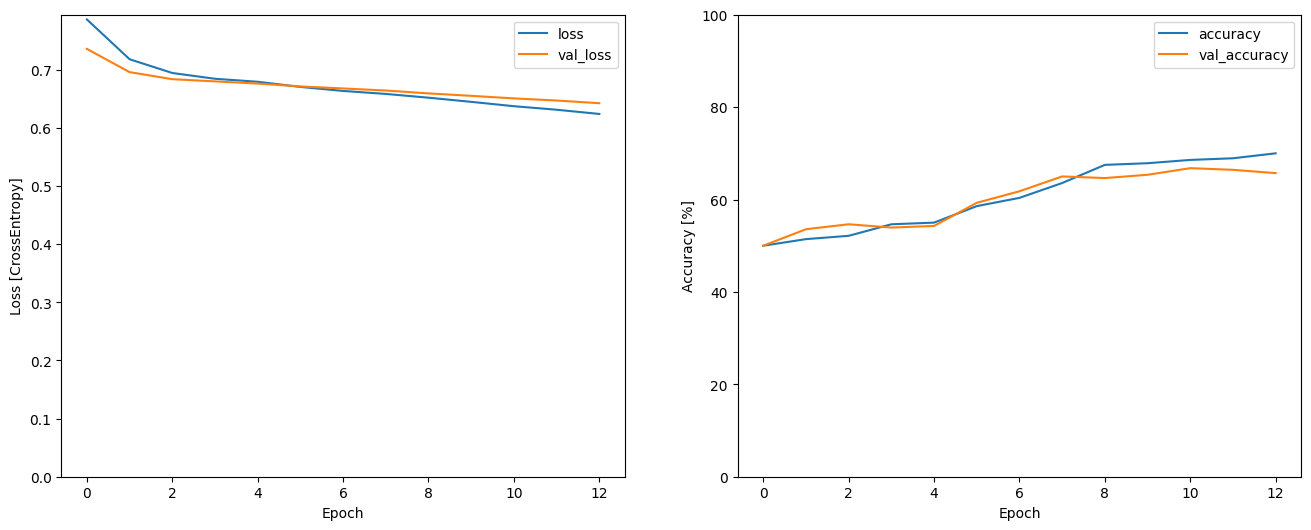

In [8]:
model_mfcc_conv = get_conv_model_mini(input_shape, len(label_names))
model_mfcc_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_mfcc_conv = model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_conv)

## Raw - Spectrograms

(118, 129, 1)


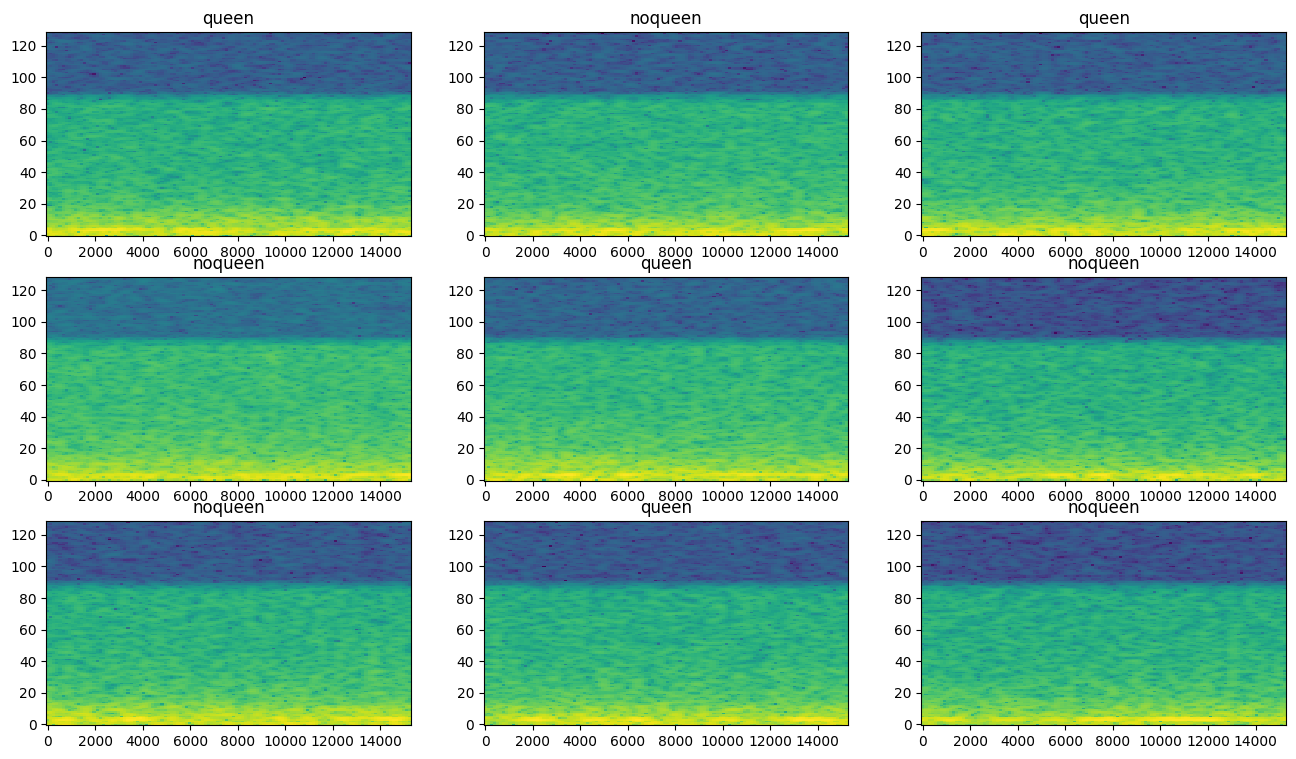

In [9]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
print(input_shape)
plot_spectrograms(example_spectrograms, example_spect_labels, label_names)

In [10]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [Spec] Sequential model

Epoch 1/20
18/18 [==============================] - 1s 29ms/step - loss: 0.6868 - accuracy: 0.5286 - val_loss: 0.6976 - val_accuracy: 0.5179
Epoch 2/20
18/18 [==============================] - 0s 16ms/step - loss: 0.6680 - accuracy: 0.6036 - val_loss: 0.7027 - val_accuracy: 0.5000
Epoch 3/20
18/18 [==============================] - 0s 15ms/step - loss: 0.6522 - accuracy: 0.6321 - val_loss: 0.6929 - val_accuracy: 0.5143
Epoch 4/20
18/18 [==============================] - 0s 15ms/step - loss: 0.6415 - accuracy: 0.6679 - val_loss: 0.6919 - val_accuracy: 0.5393
Epoch 5/20
18/18 [==============================] - 0s 16ms/step - loss: 0.6304 - accuracy: 0.6679 - val_loss: 0.6900 - val_accuracy: 0.5286
Epoch 6/20
18/18 [==============================] - 0s 15ms/step - loss: 0.6212 - accuracy: 0.6893 - val_loss: 0.6877 - val_accuracy: 0.5071


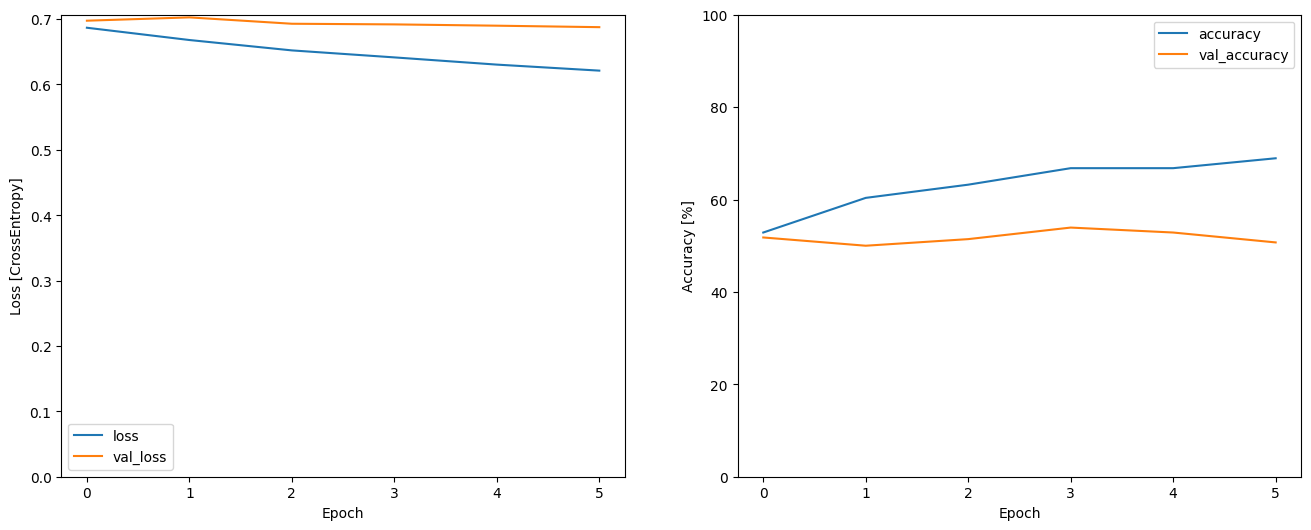

In [11]:
model_spec_seq = get_seq_model(input_shape, len(label_names), train_spectrogram_ds)
model_spec_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_spec_seq = model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_seq)

### [Reinf:Raw] [Spec] Convolutional model

Epoch 1/20
18/18 [==============================] - 1s 25ms/step - loss: 0.7433 - accuracy: 0.5036 - val_loss: 0.7516 - val_accuracy: 0.5000
Epoch 2/20
18/18 [==============================] - 0s 12ms/step - loss: 0.6957 - accuracy: 0.5429 - val_loss: 0.7084 - val_accuracy: 0.5000
Epoch 3/20
18/18 [==============================] - 0s 13ms/step - loss: 0.6942 - accuracy: 0.5036 - val_loss: 0.7030 - val_accuracy: 0.5000
Epoch 4/20
18/18 [==============================] - 0s 13ms/step - loss: 0.6799 - accuracy: 0.5071 - val_loss: 0.6875 - val_accuracy: 0.5036
Epoch 5/20
18/18 [==============================] - 0s 11ms/step - loss: 0.6767 - accuracy: 0.5500 - val_loss: 0.6862 - val_accuracy: 0.5107
Epoch 6/20
18/18 [==============================] - 0s 10ms/step - loss: 0.6730 - accuracy: 0.5643 - val_loss: 0.6861 - val_accuracy: 0.5071
Epoch 7/20
18/18 [==============================] - 0s 10ms/step - loss: 0.6741 - accuracy: 0.5214 - val_loss: 0.6865 - val_accuracy: 0.5071


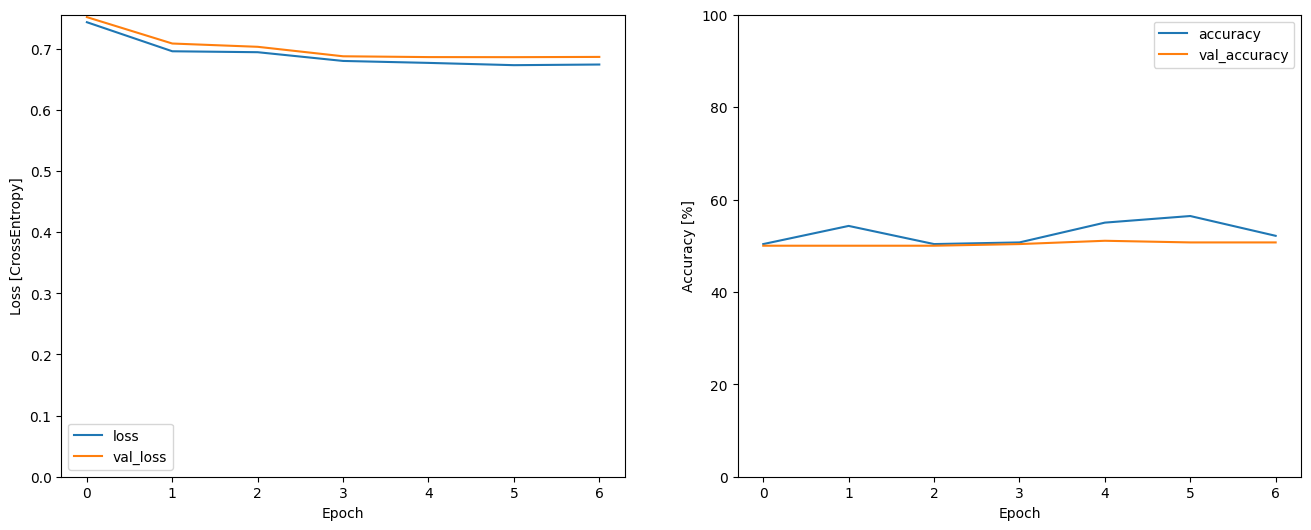

In [12]:
model_spec_conv = get_conv_model(input_shape, len(label_names))
model_spec_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_spec_conv = model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_conv)

# Pre-trained models

In [13]:
trained_model_mfcc_seq = tf.keras.models.load_model("models/mfcc_seq.h5")
trained_model_mfcc_conv = tf.keras.models.load_model("models/mfcc_conv_mini.h5")
trained_model_spec_seq = tf.keras.models.load_model("models/spec_seq.h5")
trained_model_spec_conv = tf.keras.models.load_model("models/spec_conv.h5")

In [14]:
results = trained_model_mfcc_seq.evaluate(val_mfccs_ds)
print(f"MFCC Seq: {results}")
results = trained_model_mfcc_conv.evaluate(val_mfccs_ds)
print(f"MFCC Conv: {results}")
results = trained_model_spec_seq.evaluate(val_spectrogram_ds)
print(f"Spec Seq: {results}")
results = trained_model_spec_conv.evaluate(val_spectrogram_ds)
print(f"Spec Conv: {results}")

18/18 [==============================] - 0s 8ms/step - loss: 7.8230 - accuracy: 0.5000
MFCC Seq: [7.822988510131836, 0.5]
18/18 [==============================] - 0s 5ms/step - loss: 2.8237 - accuracy: 0.5000
MFCC Conv: [2.8237102031707764, 0.5]
18/18 [==============================] - 0s 8ms/step - loss: 2.5039 - accuracy: 0.5000
Spec Seq: [2.50390625, 0.5]
18/18 [==============================] - 0s 6ms/step - loss: 4.4163 - accuracy: 0.5000
Spec Conv: [4.4163031578063965, 0.5]


### [Reinf] [MFCCs] Sequential model

Epoch 1/20
18/18 [==============================] - 1s 21ms/step - loss: 3.2646 - accuracy: 0.4964 - val_loss: 2.3950 - val_accuracy: 0.5036
Epoch 2/20
18/18 [==============================] - 0s 15ms/step - loss: 1.4699 - accuracy: 0.5250 - val_loss: 0.8342 - val_accuracy: 0.4500
Epoch 3/20
18/18 [==============================] - 0s 15ms/step - loss: 0.8964 - accuracy: 0.5107 - val_loss: 0.7568 - val_accuracy: 0.5143
Epoch 4/20
18/18 [==============================] - 0s 15ms/step - loss: 0.8208 - accuracy: 0.5393 - val_loss: 0.7518 - val_accuracy: 0.4893
Epoch 5/20
18/18 [==============================] - 0s 15ms/step - loss: 0.7794 - accuracy: 0.5286 - val_loss: 0.7654 - val_accuracy: 0.4536
Epoch 6/20
18/18 [==============================] - 0s 15ms/step - loss: 0.7648 - accuracy: 0.5393 - val_loss: 0.7711 - val_accuracy: 0.4607


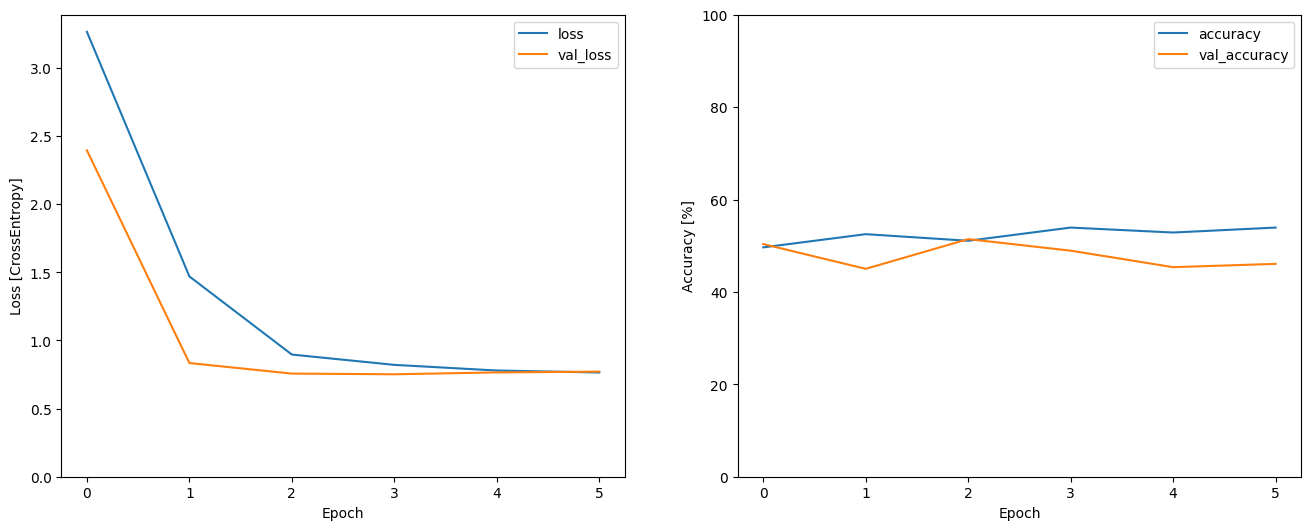

In [15]:
trained_history_mfcc_seq = trained_model_mfcc_seq.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_mfcc_seq)

### [Reinf] [MFCCs] Convolutional model (mini)

Epoch 1/20
18/18 [==============================] - 0s 12ms/step - loss: 1.6108 - accuracy: 0.4929 - val_loss: 0.7588 - val_accuracy: 0.4857
Epoch 2/20
18/18 [==============================] - 0s 7ms/step - loss: 0.7808 - accuracy: 0.5286 - val_loss: 0.6808 - val_accuracy: 0.5357
Epoch 3/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6620 - accuracy: 0.6393 - val_loss: 0.6838 - val_accuracy: 0.6321
Epoch 4/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6482 - accuracy: 0.5929 - val_loss: 0.6644 - val_accuracy: 0.5679
Epoch 5/20
18/18 [==============================] - 0s 8ms/step - loss: 0.6348 - accuracy: 0.5679 - val_loss: 0.6588 - val_accuracy: 0.5607
Epoch 6/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6303 - accuracy: 0.6214 - val_loss: 0.6550 - val_accuracy: 0.5964
Epoch 7/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6281 - accuracy: 0.5964 - val_loss: 0.6524 - val_accuracy: 0.5714
Epoch 8/20
18/18 [=

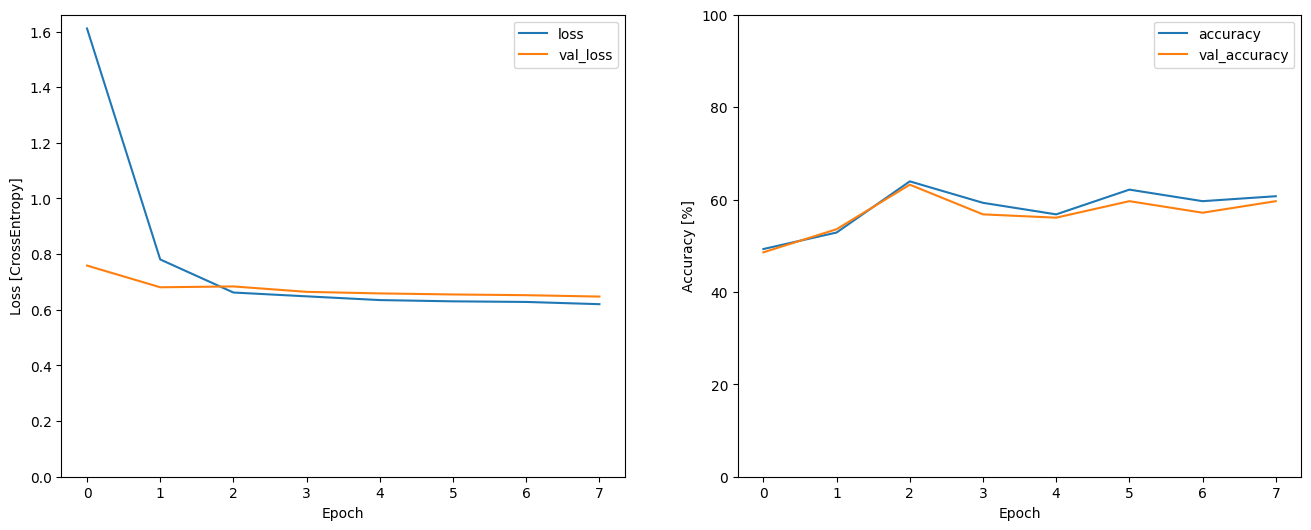

In [16]:
trained_history_mfcc_conv = trained_model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_mfcc_conv)

### [Reinf] [Spec] Sequential model

Epoch 1/20
18/18 [==============================] - 1s 21ms/step - loss: 1.5482 - accuracy: 0.4464 - val_loss: 0.8868 - val_accuracy: 0.4786
Epoch 2/20
18/18 [==============================] - 0s 15ms/step - loss: 0.9021 - accuracy: 0.5179 - val_loss: 0.8904 - val_accuracy: 0.5036
Epoch 3/20
18/18 [==============================] - 0s 15ms/step - loss: 0.7950 - accuracy: 0.5786 - val_loss: 0.7938 - val_accuracy: 0.5000
Epoch 4/20
18/18 [==============================] - 0s 16ms/step - loss: 0.7138 - accuracy: 0.6000 - val_loss: 0.8144 - val_accuracy: 0.5429
Epoch 5/20
18/18 [==============================] - 0s 17ms/step - loss: 0.6885 - accuracy: 0.6214 - val_loss: 0.7724 - val_accuracy: 0.4929
Epoch 6/20
18/18 [==============================] - 0s 16ms/step - loss: 0.6675 - accuracy: 0.6250 - val_loss: 0.7855 - val_accuracy: 0.5464
Epoch 7/20
18/18 [==============================] - 0s 17ms/step - loss: 0.6566 - accuracy: 0.6143 - val_loss: 0.7534 - val_accuracy: 0.4929
Epoch 8/20
18

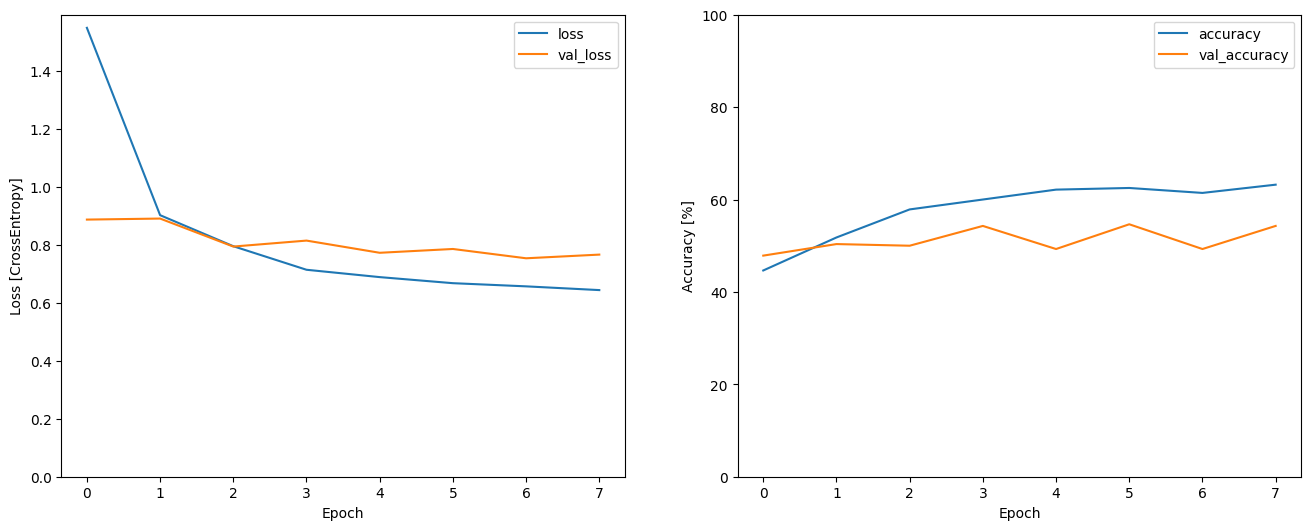

In [17]:
trained_history_spec_seq = trained_model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_spec_seq)

### [Reinf] [Spec] Convolutional model

Epoch 1/20


18/18 [==============================] - 1s 16ms/step - loss: 1.3830 - accuracy: 0.4821 - val_loss: 1.1024 - val_accuracy: 0.4821
Epoch 2/20
18/18 [==============================] - 0s 10ms/step - loss: 0.9933 - accuracy: 0.4321 - val_loss: 0.8253 - val_accuracy: 0.4286
Epoch 3/20
18/18 [==============================] - 0s 12ms/step - loss: 0.8155 - accuracy: 0.5107 - val_loss: 0.9530 - val_accuracy: 0.5214
Epoch 4/20
18/18 [==============================] - 0s 9ms/step - loss: 0.7820 - accuracy: 0.5393 - val_loss: 0.8128 - val_accuracy: 0.4607
Epoch 5/20
18/18 [==============================] - 0s 12ms/step - loss: 0.7630 - accuracy: 0.5107 - val_loss: 0.7848 - val_accuracy: 0.4750
Epoch 6/20
18/18 [==============================] - 0s 9ms/step - loss: 0.7172 - accuracy: 0.5786 - val_loss: 0.7699 - val_accuracy: 0.4857
Epoch 7/20
18/18 [==============================] - 0s 8ms/step - loss: 0.6869 - accuracy: 0.5964 - val_loss: 0.7621 - val_accuracy: 0.4929
Epoch 8/20
18/18 [=========

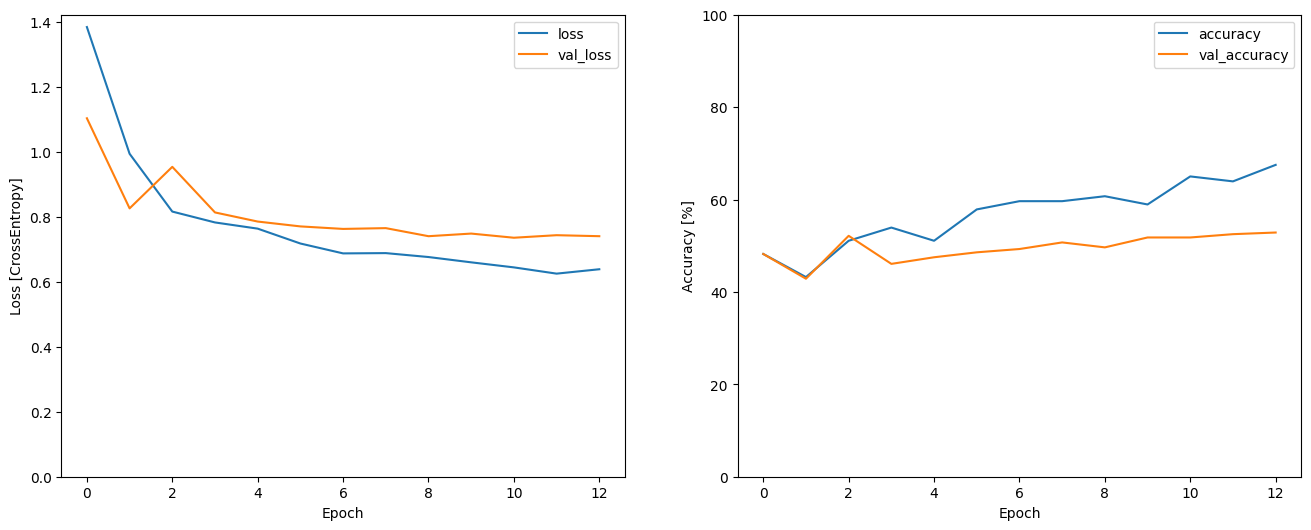

In [18]:
trained_history_spec_conv = trained_model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_spec_conv)

# Save models

In [19]:
trained_model_mfcc_seq.save('models/renf_mfcc_seq.h5')
trained_model_mfcc_conv.save('models/renf_mfcc_conv.h5')
trained_model_spec_seq.save('models/renf_spec_seq.h5')
trained_model_spec_conv.save('models/renf_spec_conv.h5')

/Users/lantain/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Summary

In [20]:
def history_to_summary(prefix: str, history):
    print(f"{prefix}:    Loss: {history.history['loss'][-1]:.2f}, Acc: {history.history['accuracy'][-1]:.2f}, VLoss: {history.history['val_loss'][-1]:.2f}, VAcc: {history.history['val_accuracy'][-1]:.2f}" )

print("=== RAW ===")
history_to_summary("MFCCs + Seq       ", history_mfcc_seq)
history_to_summary("MFCCs + Conv      ", history_mfcc_conv)
history_to_summary("Spectrogram + Seq ", history_spec_seq)
history_to_summary("Spectrogram + Conv", history_spec_conv)
print("")
print("=== TRAINED ===")
history_to_summary("Tr. MFCCs + Seq       ", trained_history_mfcc_seq)
history_to_summary("Tr. MFCCs + Conv      ", trained_history_mfcc_conv)
history_to_summary("Tr. Spectrogram + Seq ", trained_history_spec_seq)
history_to_summary("Tr. Spectrogram + Conv", trained_history_spec_conv)


=== RAW ===
MFCCs + Seq       :    Loss: 0.22, Acc: 0.95, VLoss: 0.56, VAcc: 0.68
MFCCs + Conv      :    Loss: 0.62, Acc: 0.70, VLoss: 0.64, VAcc: 0.66
Spectrogram + Seq :    Loss: 0.62, Acc: 0.69, VLoss: 0.69, VAcc: 0.51
Spectrogram + Conv:    Loss: 0.67, Acc: 0.52, VLoss: 0.69, VAcc: 0.51

=== TRAINED ===
Tr. MFCCs + Seq       :    Loss: 0.76, Acc: 0.54, VLoss: 0.77, VAcc: 0.46
Tr. MFCCs + Conv      :    Loss: 0.62, Acc: 0.61, VLoss: 0.65, VAcc: 0.60
Tr. Spectrogram + Seq :    Loss: 0.64, Acc: 0.63, VLoss: 0.77, VAcc: 0.54
Tr. Spectrogram + Conv:    Loss: 0.64, Acc: 0.68, VLoss: 0.74, VAcc: 0.53
